### Import requires libraries
This tutorial uses just Python core libraries, Scipy (Numpy, Matplotlib and others) and GDAL. For Windows users, the most effective way is to download the GDAL Wheel from https://www.lfd.uci.edu/~gohlke/pythonlibs/ and install through pip.

In [1]:
pip install parse

  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=2c2a8c8d91b2d8dba9a17a5ccc8534400e7ce673a8a63a130e54a4acbabc567f
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
Successfully built parse


In [2]:
#Import Libraries
from osgeo import ogr, gdal, osr
import numpy as np
import os
import glob
import fnmatch
from PIL import Image
import os, os.path
from pylab import *
from parse import parse
import datetime
import pandas as pd
import skimage.transform as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import seaborn as sns

import keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D
from keras.utils import np_utils
from keras.layers import LSTM
import tensorflow as tf

In [ ]:
#tf.config.run_functions_eagerly(True)

In [3]:
# Mounting the Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# To save raster
def saveRaster(dataset,datasetPath,cols,rows,projection,geotransform):
    rasterSet = gdal.GetDriverByName('GTiff').Create(datasetPath, cols, rows,1,gdal.GDT_Float32)
    rasterSet.SetProjection(projection)
    rasterSet.SetGeoTransform(geotransform)
    rasterSet.GetRasterBand(1).WriteArray(dataset)
    rasterSet.GetRasterBand(1).SetNoDataValue(-999)
    rasterSet = None

In [ ]:
#Convert Satellite Images into Arrays and Calculation of NDVI

#All images of Landsat 7-136044 scene

imgs = []
path_B4=[]
path_B5=[]
path = "../Data/136044-L7/"
df={}
i=0

# Defining Image Size
fixedX1 = 279885
fixedX2 = 504315
fixedY1 = 2662515 
fixedY2 = 2452185  
# Creating an empty Dataframe with column names only


for f in os.listdir(path):
     if fnmatch.fnmatch(f, '*B4*'):
        path_B5 = path + str(f)
        pattern = 'LE07_L2SP_136044_{Dates}_{otherstuff}.tif'
        result = parse(pattern, f)
        
        path_B4 = path + f.replace("B4.TIF", "B3.TIF")  
       
        #Open raster bands
        B5 = gdal.Open(path_B5)
        B4 = gdal.Open(path_B4)
        #Read bands as matrix arrays
        B5_Data = B5.GetRasterBand(1).ReadAsArray().astype(np.float32)
        B4_Data = B4.GetRasterBand(1).ReadAsArray().astype(np.float32)
       # Geo Transformation of satellite image
        geotransform=B5.GetGeoTransform()
        # Calculate Final Geo Spatial Coordinates
        originX,pixelWidth,empty,finalY,empty2,pixelHeight=geotransform
        cols =  B5.RasterXSize
        rows =  B5.RasterYSize
        
        projection = B5.GetProjection()
        finalX = originX + pixelWidth * cols
        originY = finalY + pixelHeight * rows
        
        # Clipping the images to a common area
        initialrow = int((finalY-fixedY1)/30)
        finalrow = int(((finalY-originY)/30)-((fixedY2-originY)/30))
        initialcol = int((fixedX1 - originX)/30)
        finalcol = int(((finalX-originX)/30)-((finalX-fixedX2)/30))
        B5_Data = B5_Data[initialrow: finalrow,initialcol : finalcol]
        B4_Data = B4_Data[initialrow: finalrow,initialcol : finalcol] 
        
        # Removing area outside satellite image 
        B5_Data = B5_Data[1000: 6000,1500 : 6000]
        B4_Data = B4_Data[1000: 6000,1500 : 6000]
        new_rr_shape=(100, 100)
        B4_Data = st.resize(B4_Data, new_rr_shape, mode='constant')
        B5_Data = st.resize(B5_Data, new_rr_shape, mode='constant')

        #Calculate NDVI
        ndvi = np.divide(B5_Data - B4_Data, B5_Data+ B4_Data,where=(B5_Data - B4_Data)!=0)
        ndvi[ndvi == 0] = -999
        df[result['Dates']] = ndvi

# Store the extracted and NDVI as .npz file      
outfile1='/content/drive/MyDrive/Landsat8/Scripts/dict_L7_044.npz'
np.savez(outfile1, **df)


In [ ]:
#Convert Satellite Images into Arrays and Calculation of NDVI

#All images of 136044 Landsat 8 scene

imgs = []
path_B4=[]
path_B5=[]
path = "../Data/136044/"
df={}
i=0

# Commom GeoSpatial Coordinates of all images
fixedX1 = 279885
fixedX2 = 504315
fixedY1 = 2662515  
fixedY2 = 2452185  


for f in os.listdir(path):
     if fnmatch.fnmatch(f, '*B5*'):
        path_B5 = path + str(f)
        pattern = 'LC08_L2SP_136044_{Dates}_{otherstuff}.tif'
        result = parse(pattern, f)

        path_B4 = path + f.replace("B5.TIF", "B4.TIF")  
    
        
        #Open raster bands
        B5 = gdal.Open(path_B5)
        B4 = gdal.Open(path_B4)
        #Read bands as matrix arrays
        B5_Data = B5.GetRasterBand(1).ReadAsArray().astype(np.float32)
        B4_Data = B4.GetRasterBand(1).ReadAsArray().astype(np.float32)
        # Geo Transformation of satellite image
        geotransform=B5.GetGeoTransform()
        # Calculate Final Geo Spatial Coordinates
        originX,pixelWidth,empty,finalY,empty2,pixelHeight=geotransform
        cols =  B5.RasterXSize
        rows =  B5.RasterYSize
        
        projection = B5.GetProjection()
        finalX = originX + pixelWidth * cols
        originY = finalY + pixelHeight * rows
        
        # Clipping the images to a common area
        initialrow = int((finalY-fixedY1)/30)
        finalrow = int(((finalY-originY)/30)-((fixedY2-originY)/30))
        initialcol = int((fixedX1 - originX)/30)
        finalcol = int(((finalX-originX)/30)-((finalX-fixedX2)/30))
        B5_Data = B5_Data[initialrow: finalrow,initialcol : finalcol]
        B4_Data = B4_Data[initialrow: finalrow,initialcol : finalcol] 

        # Removing area outside satellite image 
        B5_Data = B5_Data[1000: 6000,1500 : 6000]
        B4_Data = B4_Data[1000: 6000,1500 : 6000]
        
        # Resize array into 100*100 matrix
        new_rr_shape=(100,100)
        B4_Data = st.resize(B4_Data, new_rr_shape, mode='constant')
        B5_Data = st.resize(B5_Data, new_rr_shape, mode='constant')
        
        
        #Cakculation of NDVI
        ndvi = np.divide(B5_Data - B4_Data, B5_Data+ B4_Data,where=(B5_Data - B4_Data)!=0)
        ndvi[ndvi == 0] = -999
        df[result['Dates']] = ndvi

# Store the extracted and NDVI as .npz file      
outfile2='/content/drive/MyDrive/Landsat8/Scripts/dict_L8_044.npz'
np.savez(outfile2, **df)

In [4]:
# Read NDVI values stored in .npz file to a dataframe
def ReadNDVI(outfile, NDVIperImage):
  npzfile = np.load(outfile)
  for i in npzfile.files:
      date1 = datetime.datetime.strptime(i, "%Y%m%d").date()
      NDVIperImage = NDVIperImage.append({'Date': date1, 'NDVI': npzfile[i]}, ignore_index=True)
  return NDVIperImage

In [5]:
# Create animation of calculate NDVI of all satellite images
def CreateNDVIAnimation(NDVIperImage, filename):

  fig = plt.figure()
  ax = fig.add_subplot(111)
  ims = []
  titles = []

  for i in range(0,len(NDVIperImage)):
      title = NDVIperImage.Date[i]
      ttl = plt.text(0.5, 1.01, title, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
      im = plt.imshow(NDVIperImage.NDVI[i], cmap='RdYlGn', animated=True)
      ims.append([im,ttl])
      
  ani = animation.ArtistAnimation(fig, ims, interval=50,blit =False,repeat_delay=1000)

  plt.colorbar()
  plt.show()

  writergif = animation.PillowWriter(fps=1)
  ani.save(filename,writer=writergif)

In [6]:
# Convert the NDVI change labels into categories
def Convert_to_Category(ndviChange):
  ndviChangeLabel = ndviChange
  ndviChangeLabel = np.where(ndviChangeLabel==0,3,ndviChangeLabel)
  ndviChangeLabel = np.where(ndviChangeLabel==-999.0,3,ndviChangeLabel)
  ndviChangeLabel = np.where((ndviChangeLabel>0.0) & (ndviChangeLabel<=0.5),4,ndviChangeLabel)
  ndviChangeLabel = np.where((ndviChangeLabel>0.5) & (ndviChangeLabel<=1),5,ndviChangeLabel)
  ndviChangeLabel = np.where((ndviChangeLabel>=-1.0) & (ndviChangeLabel<-0.5),1,ndviChangeLabel)
  ndviChangeLabel = np.where((ndviChangeLabel>=-0.5) & (ndviChangeLabel<0.0),2,ndviChangeLabel)
  ndviChangeLabel = ndviChangeLabel.astype(int)
  return ndviChangeLabel

In [7]:
# Calculate NDVI change of adjacent satellite images
def CalculateNDVIChange(NDVIperImage):
  NDVIChangePerImage = {}
  for i in range(1,len(NDVIperImage)):
    DaysDifference = (NDVIperImage.loc[i].Date-NDVIperImage.loc[i-1].Date).days
    ndviChange = NDVIperImage.loc[i].NDVI-NDVIperImage.loc[i-1].NDVI
    ndviChange = np.where((NDVIperImage.loc[i-1].NDVI>-999) & (NDVIperImage.loc[i].NDVI>-999),ndviChange,-999)
    startDate = str(NDVIperImage.loc[i-1].Date)
    # NDVI Change Label
    ndviChangeLabel = Convert_to_Category(ndviChange) 
    NDVIChangePerImage[str(NDVIperImage.loc[i].Date)] = [DaysDifference, ndviChange, ndviChangeLabel,startDate ]
  return NDVIChangePerImage

In [8]:
# Create Animation of Calculated NDVI change
def CreateNDVIChangeAnimation(NDVIChangeperImage, filename):

  fig = plt.figure()
  ax = fig.add_subplot(111)
  ims = []
  titles = []
  
  for i in NDVIChangePerImage.keys():
    title = str('--'.join([NDVIChangePerImage[i][3],i]))
    ttl = plt.text(0.5, 1.01, title, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
    im = plt.imshow(NDVIChangePerImage[i][1], cmap='RdYlGn',vmin =-1, vmax =1, animated=True)
    ims.append([im,ttl])
       
  ani = animation.ArtistAnimation(fig, ims, interval=50,blit =False,repeat_delay=1000)

  plt.colorbar()
  plt.show()

  writergif = animation.PillowWriter(fps=1)
  ani.save(filename,writer=writergif)

In [9]:
# Create LSTM Model
def CreateLSTMModel():
  model = Sequential()
  model.add(LSTM(10000, batch_input_shape=(1, 1, 10000), stateful=True, return_sequences=True))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [10]:
# Calculate RMSE
def CalculateRMSE(pred,original):
  RMSE = 0
  for i in range(0,pred.shape[0]):
      testScore = 0
      testScore = math.sqrt(mean_squared_error(original[i], pred[i]))
      RMSE = RMSE + testScore
  return RMSE

In [11]:
# Code to find Best Epoch from different runa
def FitModel(model, x_train, y_train, x_test, y_test, y_test_label, epoch):
  result = pd.DataFrame(columns=['Epoch',  'Loss', 'Train RMSE', 'Test RMSE', 'Accuracy', 'Precision', 'F1 Score', 'Recall'])
  loss = []
  for i in range(epoch):
    history = model.fit(x_train, y_train, epochs=5, batch_size=1, verbose=1, shuffle=False)
    pred_train = model.predict(x_train, batch_size=1)
    train_RMSE = CalculateRMSE(pred_train,y_train)
    pred_test = model.predict(x_test, batch_size=1)
    test_RMSE = CalculateRMSE(pred_test, y_test)
    pred_test_label = Convert_to_Category(pred_test)
    pred_test_label = pred_test_label.reshape(pred_test_label.shape[0]*10000)
    accuracy = accuracy_score(y_test_label, pred_test_label)
    precision = precision_score(y_test_label, pred_test_label, average='weighted')
    f1 = f1_score(y_test_label, pred_test_label, average='weighted')
    recall = recall_score(y_test_label, pred_test_label, average='weighted')
    Loss = history.history['loss'][4]
    print(history.history['loss'])
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("F1 Score", f1)
    print("Recall:", recall)
    report = classification_report(y_test_label, pred_test_label)
    print(report)
    cm = confusion_matrix(y_test_label, pred_test_label)
    print(cm)
    
    
    cm_df = pd.DataFrame(cm,
                     index = ['Decrease','Increase'], 
                     columns = ['Decrease','Increase'])
    #Plotting the confusion matrix
    plt.figure(figsize=(7,4))
    sns.heatmap(cm_df, annot=True, fmt ='g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
    result = result.append({'Epoch': 5*(i+1), 'Loss': Loss, 'Train RMSE': train_RMSE, 'Test RMSE': test_RMSE, 'Accuracy':accuracy,
                            'Precision':precision, 'F1 Score': f1, 'Recall': recall}, ignore_index=True)
    loss = loss + history.history['loss']
  plt.plot(loss)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  return result

In [12]:
# NPZ file contain date and calculated NDVI
outfile1='/content/drive/MyDrive/Landsat8/Data/dict_L7_044.npz'
outfile2='/content/drive/MyDrive/Landsat8/Data/dict_L8_044.npz'

# Reading the date and NDVI into a dataframe
NDVIperImage = pd.DataFrame(columns=['Date', 'NDVI'])
NDVIperImage = ReadNDVI(outfile1,NDVIperImage)
NDVIperImage = ReadNDVI(outfile2,NDVIperImage)
NDVIperImage = NDVIperImage.sort_values(by="Date")
print(len(NDVIperImage))

53


In [24]:
print(NDVIperImage)

          Date                                               NDVI
0   2001-02-07  [[0.17749493, 0.17150255, 0.1796221, 0.1905182...
1   2003-01-28  [[0.1274454, 0.13237932, 0.14038557, 0.1478961...
2   2003-03-01  [[0.15637892, 0.16293101, 0.16788901, 0.170228...
3   2003-11-12  [[0.3289147, 0.3256154, 0.3300582, 0.36514193,...
4   2003-12-14  [[0.25510597, 0.2588048, 0.27338657, 0.3042845...
5   2004-02-16  [[0.157148, 0.15892291, 0.16515994, 0.17137142...
6   2006-02-05  [[0.12717661, 0.12461855, 0.12844226, 0.127997...
7   2006-11-04  [[0.32248768, 0.32348493, 0.32696554, 0.355592...
8   2006-12-06  [[0.24643984, 0.2500997, 0.24986169, 0.2737693...
9   2007-01-23  [[0.17461269, 0.18185039, 0.183841, 0.19469517...
10  2007-02-24  [[0.16707917, 0.16909425, 0.1721012, 0.1728601...
11  2007-03-12  [[0.16935934, 0.18600865, 0.18109587, 0.185679...
12  2007-03-28  [[0.1755873, 0.19878727, 0.19437031, 0.1964064...
13  2007-12-25  [[0.20373766, 0.21127458, 0.21257539, 0.235158...
14  2008-0

Text(0.5, 1.0, 'NDVI Change2013-12-17--2018-12-31')

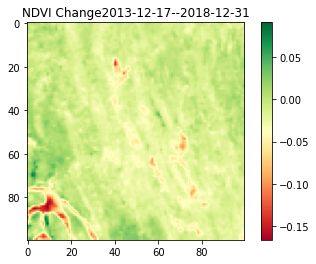

In [14]:
# NDVI change between Dec 2013 and Dec 2018
i =46
DaysDifference = (NDVIperImage.loc[i].Date-NDVIperImage.loc[24].Date).days
ndviChange = NDVIperImage.loc[i].NDVI-NDVIperImage.loc[24].NDVI
ndviChange = np.where((NDVIperImage.loc[24].NDVI>-999) & (NDVIperImage.loc[i].NDVI>-999),ndviChange,-999)
startDate = str(NDVIperImage.loc[24].Date)
finaldate = str(NDVIperImage.loc[i].Date)
title = str('--'.join([startDate,finaldate]))
img = ndviChange

plt.imshow(img, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI Change{}'.format(title))

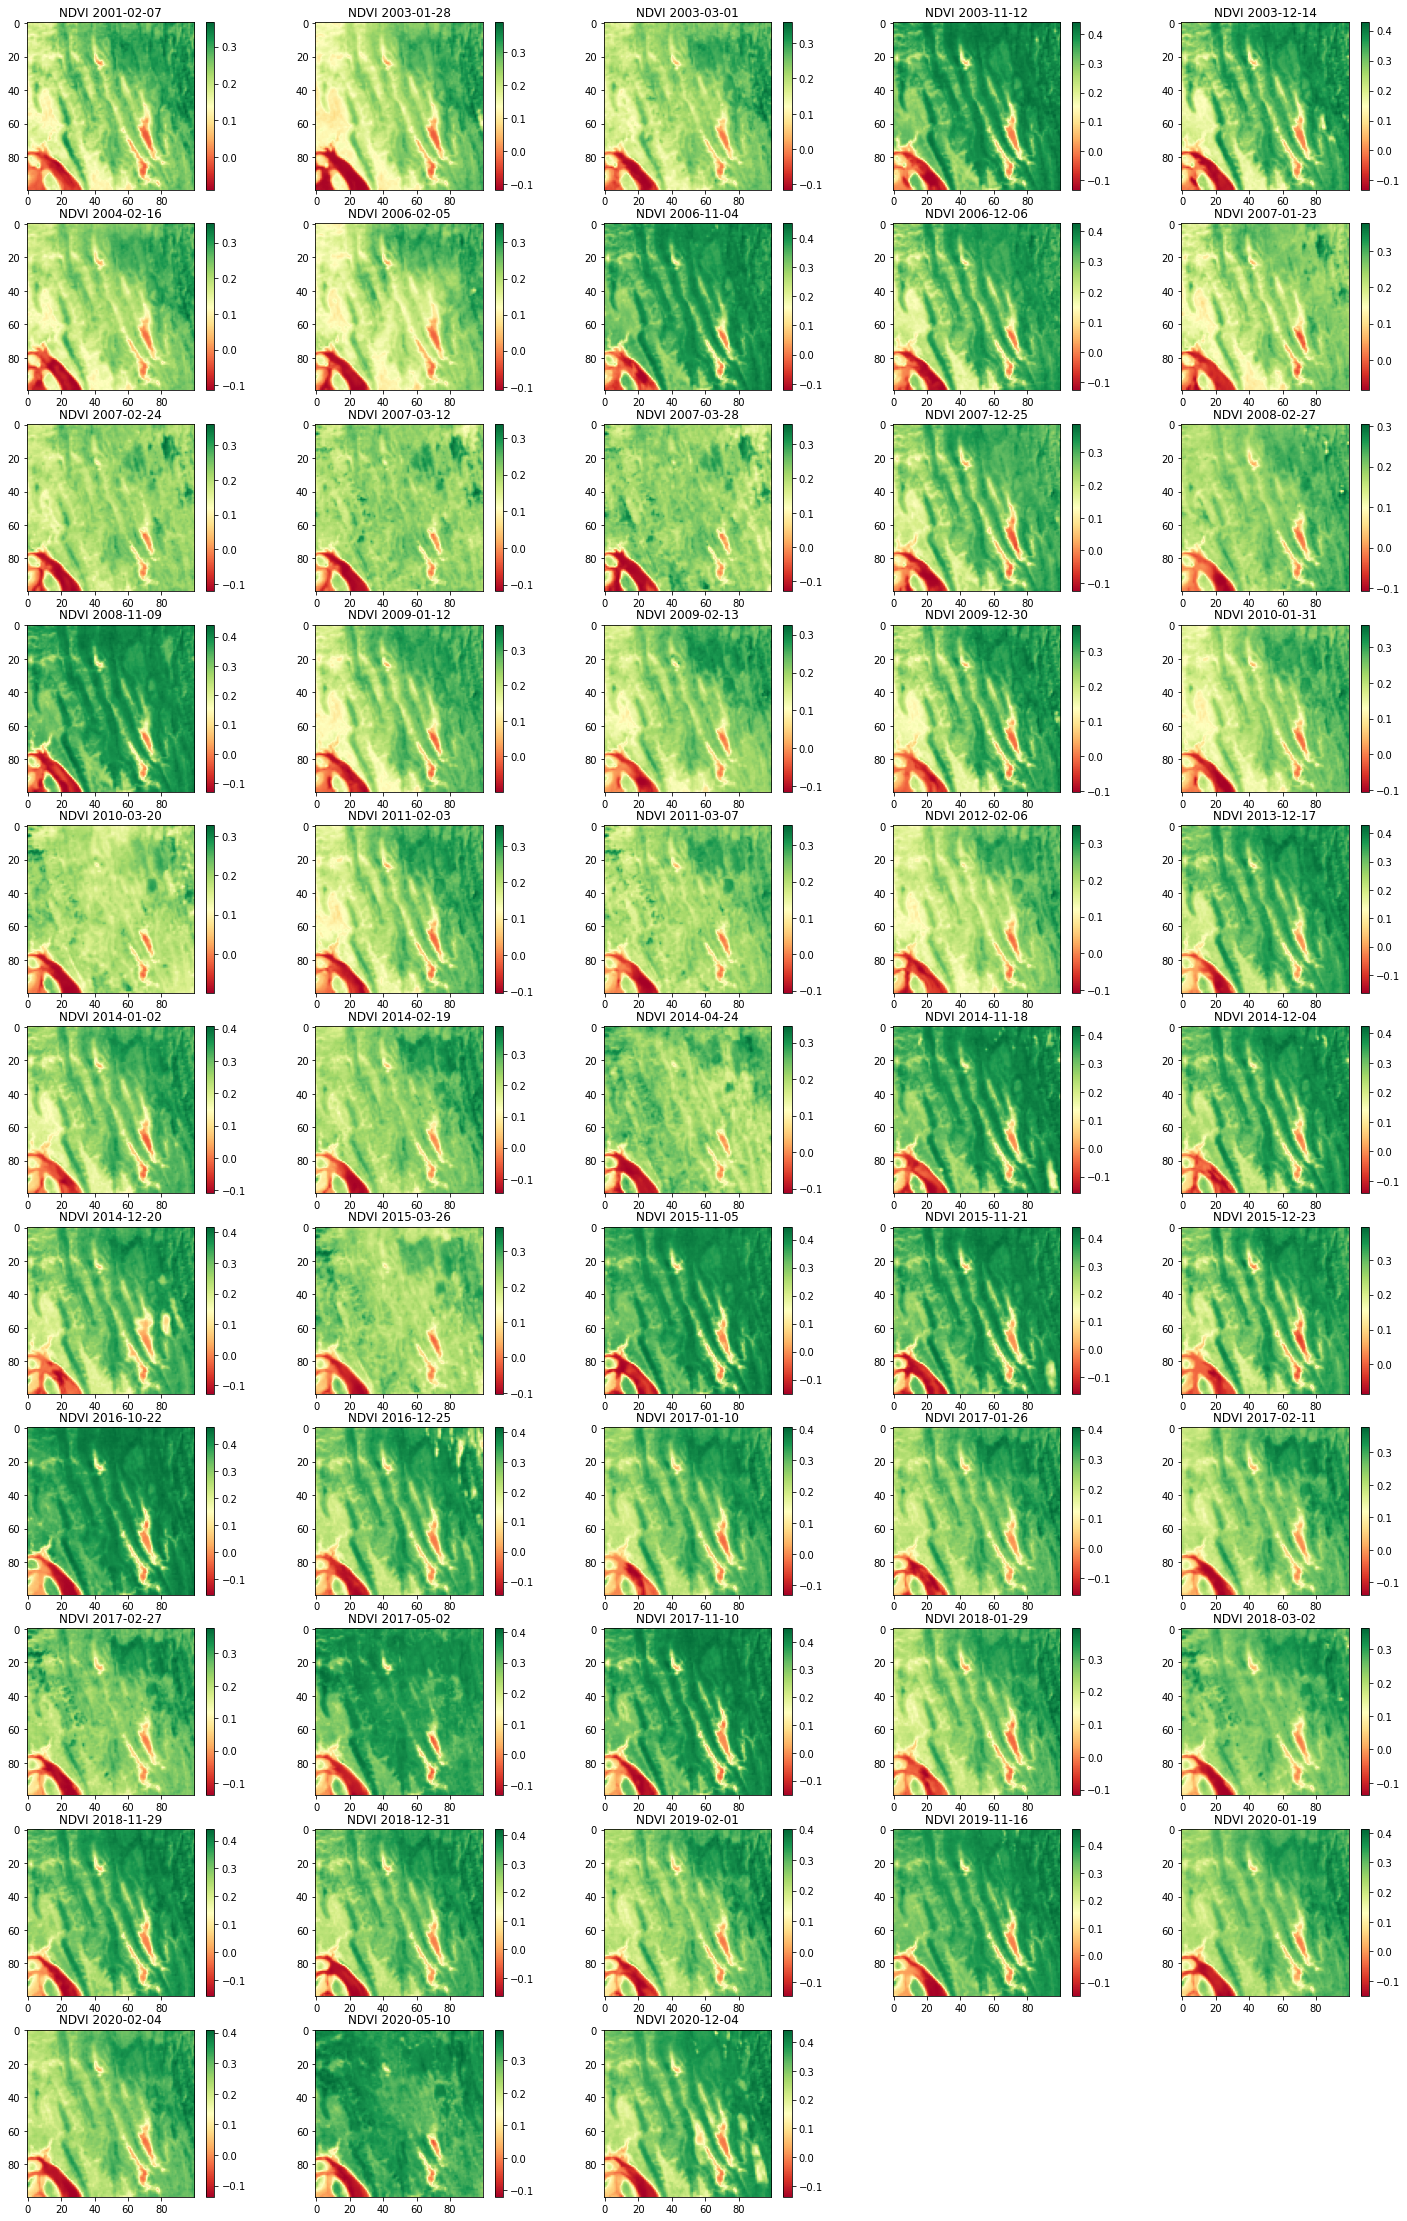

In [16]:
# Plotting Calculted NDVI 
fig = plt.figure(figsize=(25, 40))
columns = 5
rows = 11
for i in range(0, len(NDVIperImage)):
    img = NDVIperImage.NDVI[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap='RdYlGn')
    plt.colorbar()
    plt.title('NDVI {}'.format(NDVIperImage.Date[i]))
plt.show()

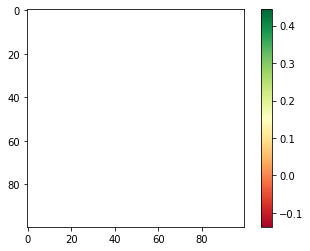

In [15]:
# Create a gif in Google Drive
NDVIAnimation = '/content/drive/MyDrive/Landsat8/Output/NDVI.gif'
CreateNDVIAnimation(NDVIperImage, NDVIAnimation)

In [16]:
# Calculate NDVI Change
NDVIChangePerImage = CalculateNDVIChange(NDVIperImage)
print(len(NDVIChangePerImage.keys()))
#print(NDVIChangePerImage)

52


In [25]:
print(NDVIChangePerImage)

{'2003-01-28': [720, array([[-0.05004953, -0.03912322, -0.03923653, ...,  0.00888789,
         0.01834849,  0.00682178],
       [-0.04126665, -0.03795671, -0.03371944, ...,  0.01030052,
         0.00197011,  0.01140201],
       [-0.042752  , -0.04181856, -0.03597692, ...,  0.01403075,
         0.00466105,  0.00773472],
       ...,
       [-0.13987748, -0.11543112, -0.10146571, ...,  0.0277054 ,
         0.0208379 ,  0.03649977],
       [-0.09766477, -0.09585281, -0.09428753, ...,  0.03047457,
         0.02749404,  0.03217033],
       [-0.09381898, -0.08995863, -0.09186319, ...,  0.03537995,
         0.03614062,  0.04296392]], dtype=float32), array([[2, 2, 2, ..., 4, 4, 4],
       [2, 2, 2, ..., 4, 4, 4],
       [2, 2, 2, ..., 4, 4, 4],
       ...,
       [2, 2, 2, ..., 4, 4, 4],
       [2, 2, 2, ..., 4, 4, 4],
       [2, 2, 2, ..., 4, 4, 4]]), '2001-02-07'], '2003-03-01': [32, array([[ 0.02893353,  0.03055169,  0.02750345, ..., -0.04624763,
        -0.05779341, -0.05179569],
       [ 0

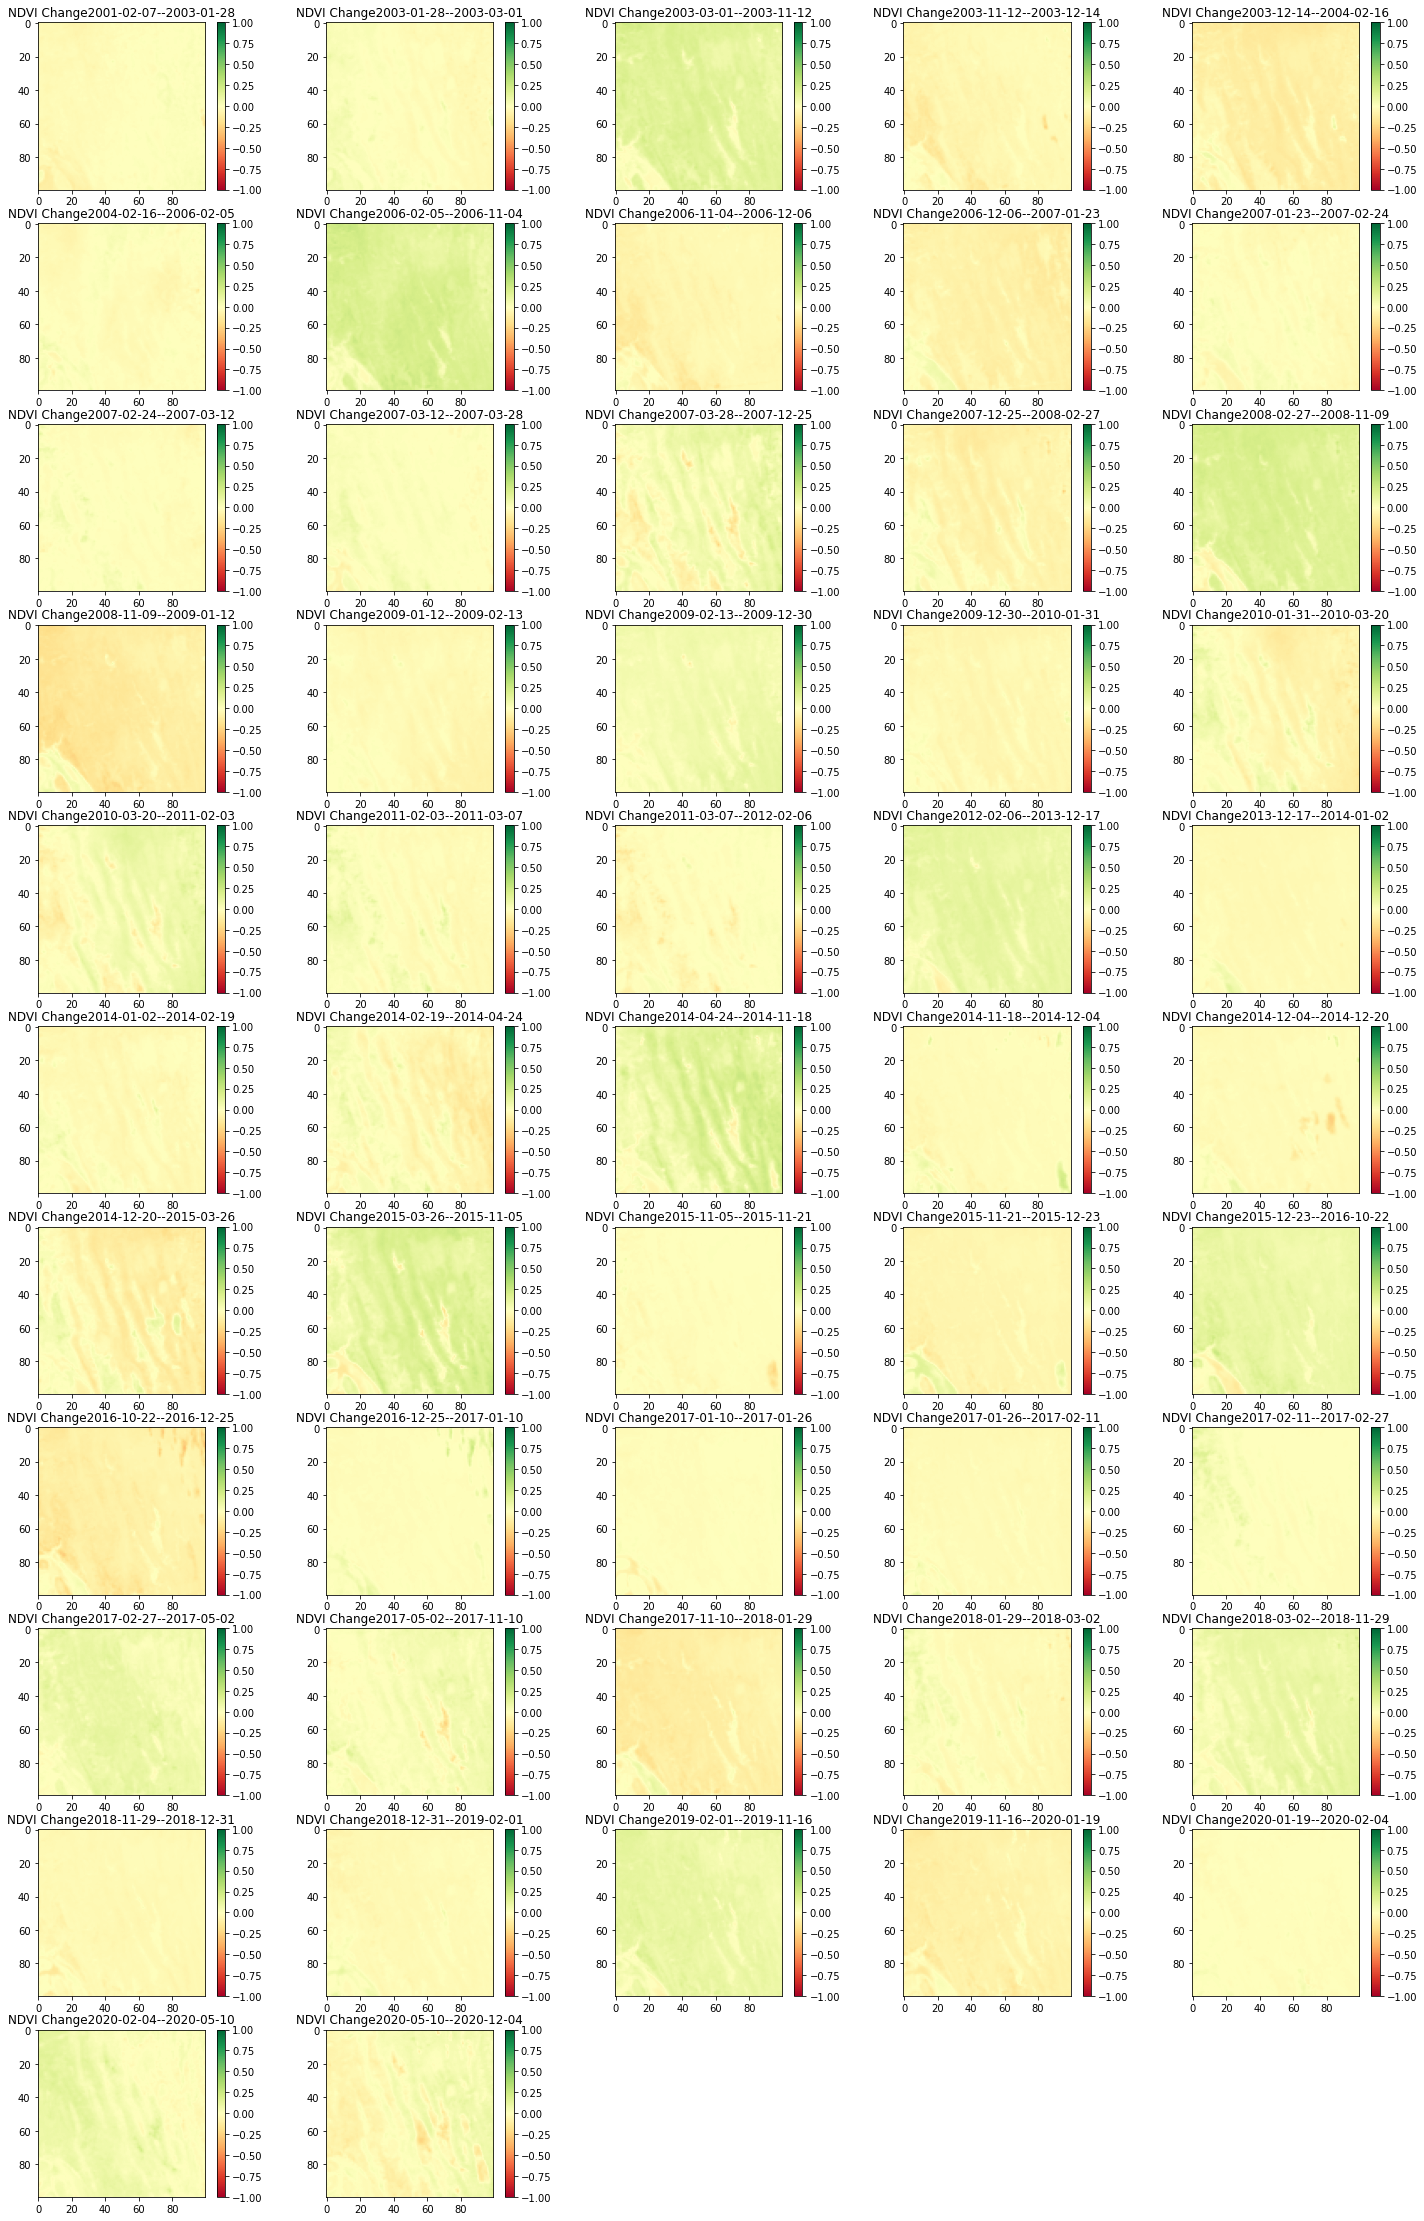

In [85]:
#Plotting NDVI Change
fig = plt.figure(figsize=(25, 40))
columns = 5
rows = 11
j=1
for i in NDVIChangePerImage:
    title = str('--'.join([NDVIChangePerImage[i][3],i]))
    img = NDVIChangePerImage[i][1]
    fig.add_subplot(rows, columns, j)
    j = j+1
    plt.imshow(img, cmap='RdYlGn',vmin =-1, vmax =1)
    plt.colorbar()
    plt.title('NDVI Change{}'.format(title))
plt.show()

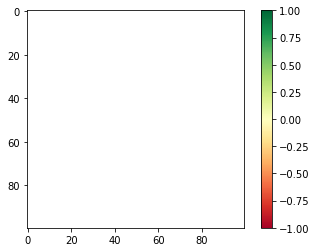

In [17]:
# Create gif in google drive
NDVIChangeAnimation = '/content/drive/MyDrive/Landsat8/Output/NDVIChange.gif'
CreateNDVIChangeAnimation(NDVIChangePerImage,NDVIChangeAnimation)

In [18]:
# Create arrays of NDVI change and NDVI change label
x = []
y = []
for d,ndvi,label,t in NDVIChangePerImage.values():
    x.append(ndvi)
    y.append(label)

In [19]:
# Create x_train, y_train x_test and y_test
x_train = x[0:42]
y_train = x[1:43]
x_test = x[42:51]
y_test = x[43:52]
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test_label = y[42:51]
y_test_label = y[43:52]
x_test_label = np.array(x_test_label)
y_test_label = np.array(y_test_label)


In [20]:
print(y_train.shape)
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)

(42, 100, 100)
(42, 100, 100)
(9, 100, 100)
(9, 100, 100)


In [21]:
# Reshapping the training and testing dataset for LSTM model training
# LSTM requires input in 3D shape
x_train = x_train.reshape(x_train.shape[0],1,10000)
y_train = y_train.reshape(y_train.shape[0],1,10000)
x_test = x_test.reshape(x_test.shape[0],1,10000)
y_test = y_test.reshape(y_test.shape[0],1,10000)
y_test_label = y_test_label.reshape(y_test_label.shape[0]*10000)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(y_test_label.shape)

(42, 1, 10000) (42, 1, 10000)
(9, 1, 10000) (9, 1, 10000)
(90000,)


In [22]:
#Defining the model
model = CreateLSTMModel()
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1, 10000)             800040000 
                                                                 
Total params: 800,040,000
Trainable params: 800,040,000
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
##Code to find the Best model 
# epoch = 20 
# results = FitModel(model, x_train, y_train, x_test, y_test, y_test_label, epoch)
# print(results)
#results.to_csv('/content/drive/MyDrive/Landsat8/Scripts/ModelEvaluation.csv', index=False)

In [23]:
# Training Model with Best epoch = 20
history = model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=1, shuffle=False)
# Predicting the NDVI change for training dataset
pred_train = model.predict(x_train, batch_size=1)
# Calculating Training RMSE
train_RMSE = CalculateRMSE(pred_train,y_train)
print("Train RMSE of full training dataset: ",train_RMSE)
# Predicting the NDVI change for tesing dataset
pred_test = model.predict(x_test, batch_size=1)
test_RMSE = CalculateRMSE(pred_test, y_test)
print("Test RMSE of full testing dataset: ",test_RMSE)
# Converting to categories
pred_test_label = Convert_to_Category(pred_test)
pred_test_label = pred_test_label.reshape(pred_test_label.shape[0]*10000)
accuracy = accuracy_score(y_test_label, pred_test_label)
precision = precision_score(y_test_label, pred_test_label, average='weighted')
f1 = f1_score(y_test_label, pred_test_label, average='weighted')
recall = recall_score(y_test_label, pred_test_label, average='weighted')


Epoch 1/20
42/42 [==============================] - 112s 2s/step - loss: 0.0064
Epoch 2/20
42/42 [==============================] - 103s 2s/step - loss: 0.0115
Epoch 3/20
42/42 [==============================] - 103s 2s/step - loss: 0.0334
Epoch 4/20
42/42 [==============================] - 103s 2s/step - loss: 0.0297
Epoch 5/20
42/42 [==============================] - 104s 2s/step - loss: 0.0138
Epoch 6/20
42/42 [==============================] - 101s 2s/step - loss: 0.0082
Epoch 7/20
42/42 [==============================] - 104s 2s/step - loss: 0.0061
Epoch 8/20
42/42 [==============================] - 99s 2s/step - loss: 0.0049
Epoch 9/20
42/42 [==============================] - 99s 2s/step - loss: 0.0044
Epoch 10/20
42/42 [==============================] - 101s 2s/step - loss: 0.0039
Epoch 11/20
42/42 [==============================] - 100s 2s/step - loss: 0.0036
Epoch 12/20
42/42 [==============================] - 99s 2s/step - loss: 0.0035
Epoch 13/20
42/42 [=====================

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
print(pred_test)

[[[ 0.01789241  0.01832622  0.02755503 ... -0.01707084 -0.03569458
    0.09155051]]

 [[ 0.09708198  0.0826816   0.04429723 ...  0.17170268 -0.08137156
    0.18034239]]

 [[-0.00987998 -0.02046981 -0.02588951 ... -0.00472166 -0.00746212
   -0.02100464]]

 ...

 [[ 0.01694212 -0.00047073 -0.0028041  ... -0.03271428 -0.06867226
   -0.00463926]]

 [[ 0.00664453 -0.01537886  0.00900873 ...  0.10429695 -0.11327951
   -0.00187187]]

 [[ 0.11387545 -0.10718586 -0.04503091 ...  0.1328657  -0.01367741
    0.11284421]]]


In [27]:

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("F1 Score", f1)
print("Recall:", recall)
report = classification_report(y_test_label, pred_test_label)
print(report)

Accuracy:  0.6745777777777778
Precision:  0.6804090706028668
F1 Score 0.6762571159290259
Recall: 0.6745777777777778


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.74      0.68      0.71     52027
           4       0.60      0.67      0.63     37973
           5       0.00      0.00      0.00         0

    accuracy                           0.67     90000
   macro avg       0.34      0.34      0.34     90000
weighted avg       0.68      0.67      0.68     90000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# Calculating Confusion Matrix
cm = confusion_matrix(y_test_label, pred_test_label)
print(cm)

[[    0     0     0     0]
 [   12 35451 16564     0]
 [    8 12703 25261     1]
 [    0     0     0     0]]


In [31]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['High Decrease','Decrease','Increase', 'High Increase'], 
                     columns = ['High Decrease','Decrease','Increase', 'High Increase'])

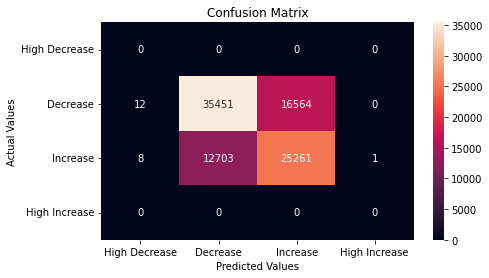

In [32]:
#Plotting the confusion matrix

plt.figure(figsize=(7,4))
sns.heatmap(cm_df, annot=True, fmt ='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [29]:
# Convering the image to 100*100 matrix
pred_img = pred_test.reshape(9,100,100)
actual_img = y_test.reshape(9, 100, 100)


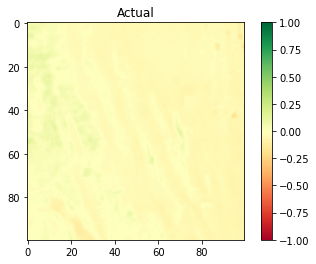

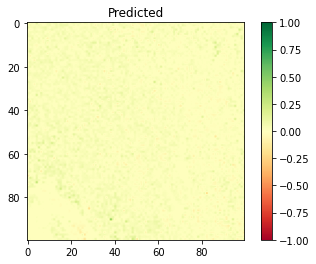

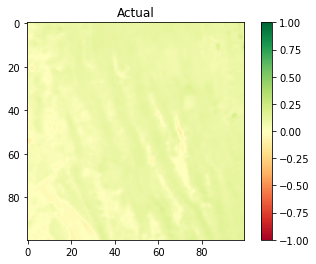

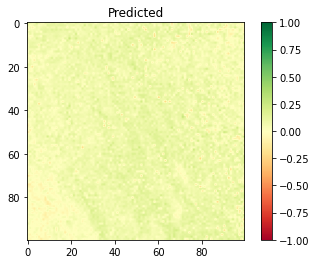

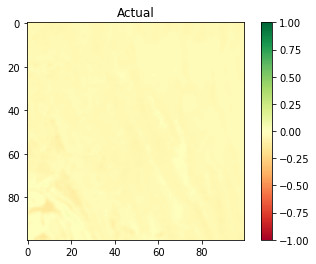

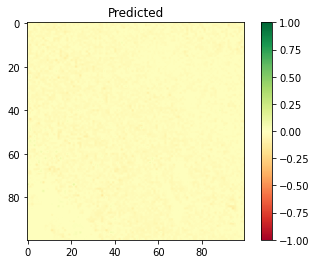

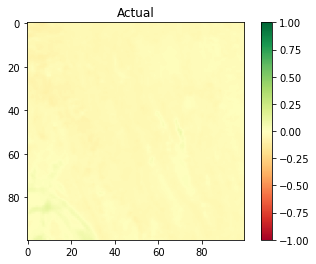

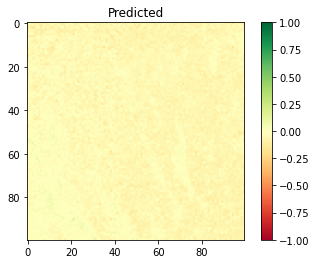

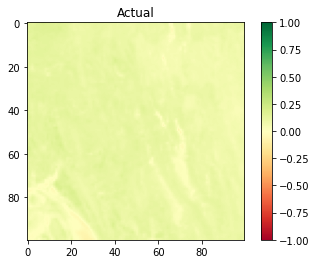

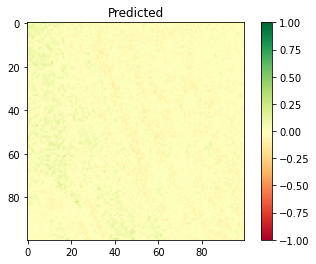

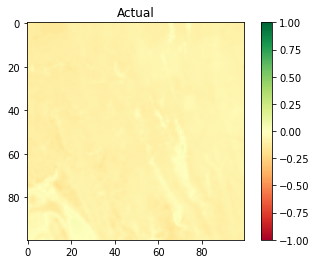

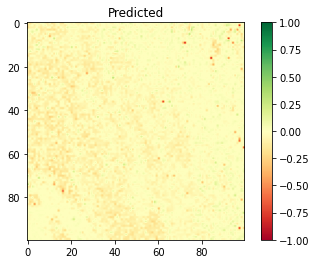

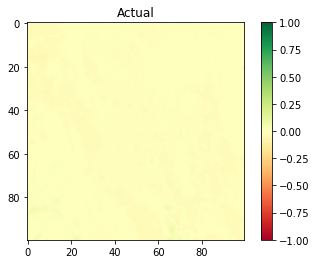

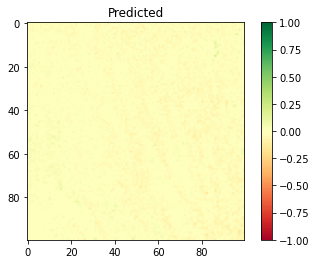

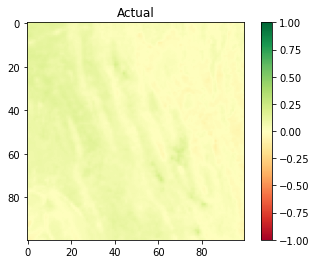

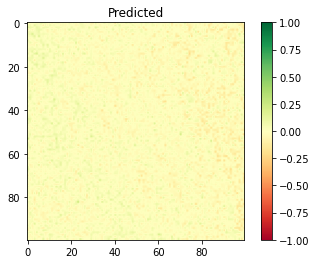

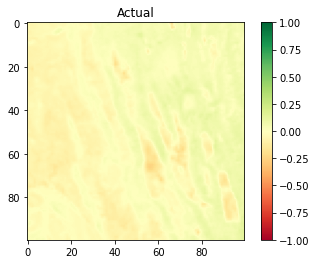

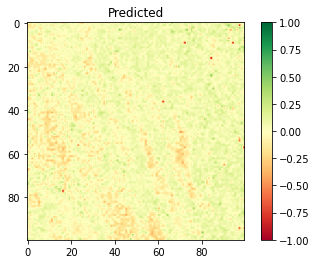

In [30]:
# Printing Actual and Predicted NDVI change
for i in range(0,actual_img.shape[0]):
    plt.imshow(actual_img[i], cmap='RdYlGn', vmax=1, vmin =-1)
    plt.colorbar()
    plt.title('Actual')
    
    plt.show()
    #plt.show(block=False)
    
    plt.imshow(pred_img[i], cmap='RdYlGn', vmax=1, vmin =-1)
    plt.colorbar()
    plt.title('Predicted')
    #plt.title('NDVI {}'.format(date))
 
    plt.show(block=False)
